# Corona

attacking MC kr events 

to use:     
1) fetch my (github/abotas) icaro WalkthroughCorona    
2) fetch my IC-1 branch corona.     
3) source manage.sh work_in_blah_blah 3.6   
4) download pmap and dst file for a run    
5) make sure you have IC_DATA and ICARO in your path
6) run

In [1]:
%matplotlib inline

import os
import sys
import random
import tables as tb
import numpy  as np

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D

from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import units
from invisible_cities.reco.pmaps_functions import load_pmaps, integrate_charge, plot_s2si_map, select_si_slice
from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps
from   invisible_cities.reco.xy_algorithms import barycenter, corona
sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')
from   icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2
from invisible_cities.core.core_functions import in_range
from detector_response_functions import gather_montecarlo_hits
import invisible_cities.core.fit_functions as fitf

NSIPM = 1792
Co = True
Na = False
Kr = False
T     =  .1*units.pes
msipm =  3
rmax  =  25*units.mm # if < 10mm won't see plots because xrms,yrms=0 sicne pitch=10mm

Load data files

In [2]:
run_number = 0
sub_run    = '0'
ic_data = os.path.join(os.environ['IC_DATA'])
if Co:
    pmap_path  = ic_data + '/Montecarlo/ir_co170419/dst_NEXT_v0_08_09_Co56_INTERNALPORTANODE_{}_0_7bar_pmaps_10000.root.h5'.format(sub_run)
if Na:
    pmap_path  = ic_data + '/Montecarlo/na170426_ir/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_{}_0_7bar_pmaps_10000.root.h5'.format(sub_run)
if Kr:
    pmap_path  = ic_data + '/Montecarlo/kr_ir170330/dst_NEXT_v0_08_09_Kr_ACTIVE_{}_0_7bar_pmaps_10000.root.h5'.format(sub_run)     

#### PMAP

In [3]:
S1s, S2s, S2Sis = load_pmaps(pmap_path)

In [4]:
with tb.open_file(pmap_path, 'r') as f: 
    print(f)
    print('')
    print('We are missing an event in MCTracks, and the rest of the files dont have MCTracks')
    print(f.root.Run.events [-1])
    print('---')
    print(f.root.MC.MCTracks[-1])

/Users/alej/Desktop/IC_DATA//Montecarlo/ir_co170419/dst_NEXT_v0_08_09_Co56_INTERNALPORTANODE_0_0_7bar_pmaps_10000.root.h5 (File) ''
Last modif.: 'Thu May  4 12:52:45 2017'
Object Tree: 
/ (RootGroup) ''
/MC (Group) ''
/MC/MCTracks (Table(433644,), shuffle, zlib(4)) 'MCTracks'
/PMAPS (Group) ''
/PMAPS/S1 (Table(89188,), shuffle, zlib(4)) 'S1 Table'
/PMAPS/S2 (Table(172839,), shuffle, zlib(4)) 'S2 Table'
/PMAPS/S2Si (Table(2868443,), shuffle, zlib(4)) 'S2Si Table'
/Run (Group) ''
/Run/events (Table(9997,), shuffle, zlib(4)) 'event info table'
/Run/runInfo (Table(9997,), shuffle, zlib(4)) 'run info table'


We are missing an event in MCTracks, and the rest of the files dont have MCTracks
(9999, 0)
---
(9996, 1, b'e-', 11, [-11.98213005, -55.03059769,  52.53224945], [-10.950881  , -41.91506195,  19.83451271], [ 0.96593708, -0.20839326, -0.65670747],  0.78083956, 171, 170, [-10.950881  , -41.91506195,  19.83451271],   5.65281745e+15,  0.00429156)


In [5]:
# load the SiPM (x,y) values
DataSensor = load_db.DataSiPM()
dxs = DataSensor.X.values
dys = DataSensor.Y.values

In [6]:
# A method in HitCollectionCity
def compute_xy_position(si, slice_no):
    si      = select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    
    xs, ys  = dxs[IDs], dys[IDs]
    return corona(xs, ys, Qs, rmax=rmax, T=T, msipm=msipm)

def plot_helper(si, slice_no):
    si      = select_si_slice(si, slice_no)
    IDs, Qs = map(list, zip(*si.items()))
    xs, ys  = dxs[IDs], dys[IDs]
    return xs, ys, Qs

# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_slice(l_X,l_Y,l_Q):
    """
    Plots a SiPM map in the NEW Geometry
    """
    
    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    for xx,yy,qq in zip(l_X,l_Y,l_Q):
        r = Ellipse(xy=(xx, yy), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(qq);
        ax1.add_artist(r);

    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    return ax1

### Pick an event from the list

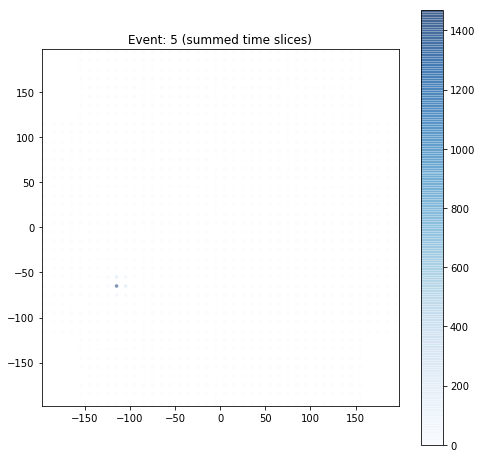

I tried to pick a more interesting looking event


In [56]:

def plot_s2si_map_tinker(S2Si, cmap='Blues'):
        """Plot a map of the energies of S2Si objects."""

        DataSensor = load_db.DataSiPM(0)
        radius = 2
        xs = DataSensor.X.values
        ys = DataSensor.Y.values
        r = np.ones(len(xs)) * radius
        col = np.zeros(len(xs))
        for sipm in S2Si.values():
            for nsipm, E in sipm.items():
                ene = np.sum(E)
                col[nsipm] = ene
        plt.figure(figsize=(8, 8))
        plt.subplot(aspect="equal")
        #circles(xs, ys, r, c=col, alpha=0.5, ec="none", cmap=cmap)
        plt.hist2d(xs, ys, 100, ((-198, 198), (-198, 198)),weights=col)
        plt.colorbar()

        plt.xlim(-198, 198)
        plt.ylim(-198, 198)


event_numbers, timestamps = get_event_numbers_and_timestamps(pmap_path)
if Kr: event_number = event_numbers[12]
if Na: event_number = event_numbers[12]
#if Co: event_number = event_numbers[4]
if Co: event_number = event_numbers[5]

peak=0
event_time   = timestamps[np.where(event_numbers==event_number)[0]]
plot_s2si_map(S2Sis[event_number])
plt.title('Event: ' + str(event_number) + ' (summed time slices)')
plt.show()
print('I tried to pick a more interesting looking event')

## Use corona (via compute_xy_position) to get the clusters for each slice

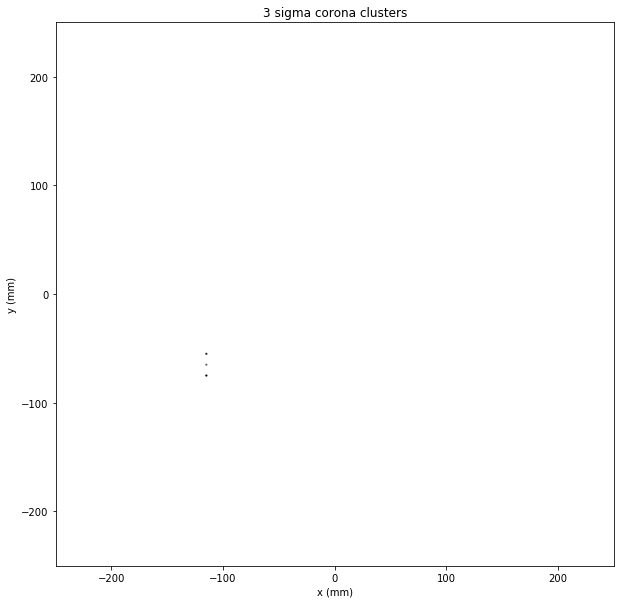

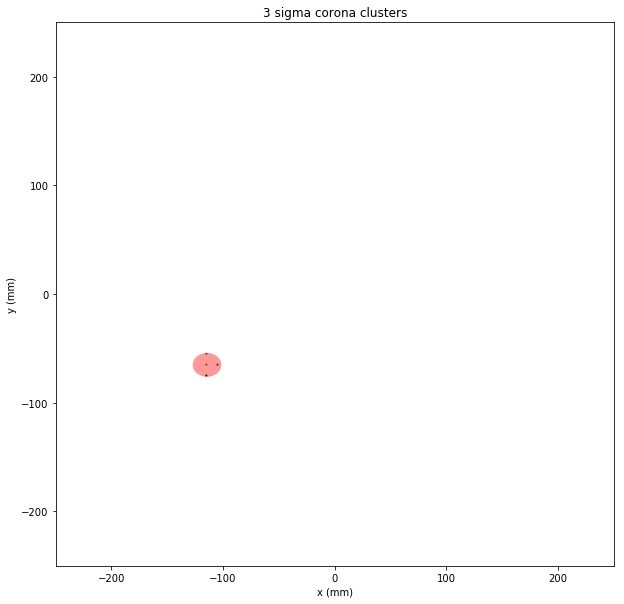

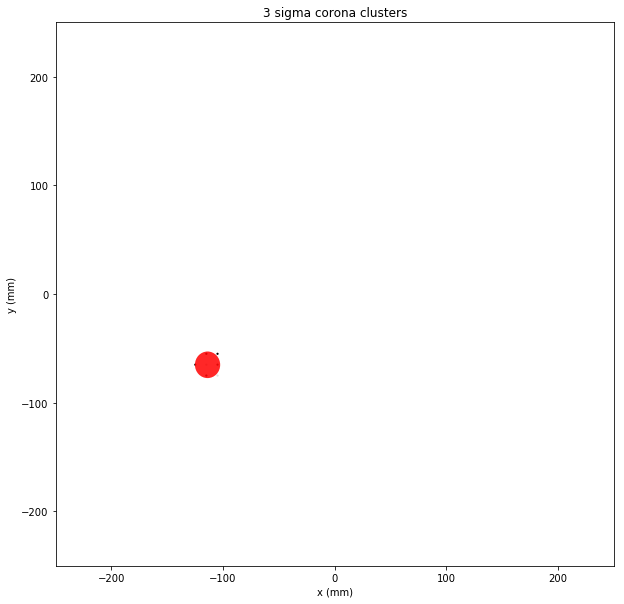

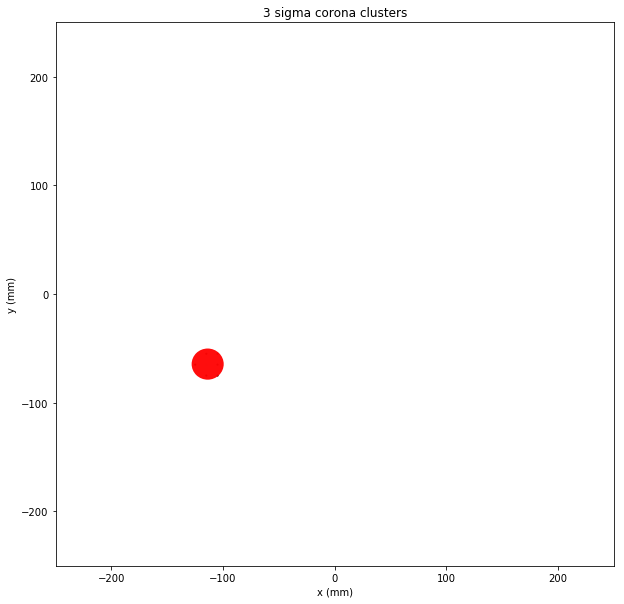

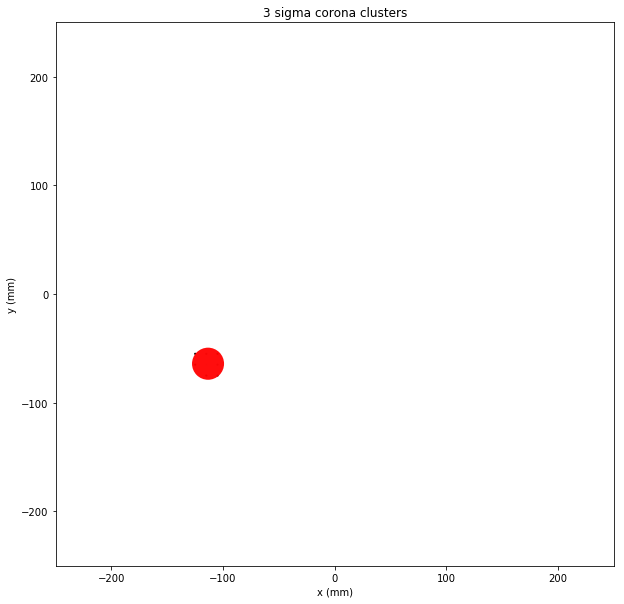

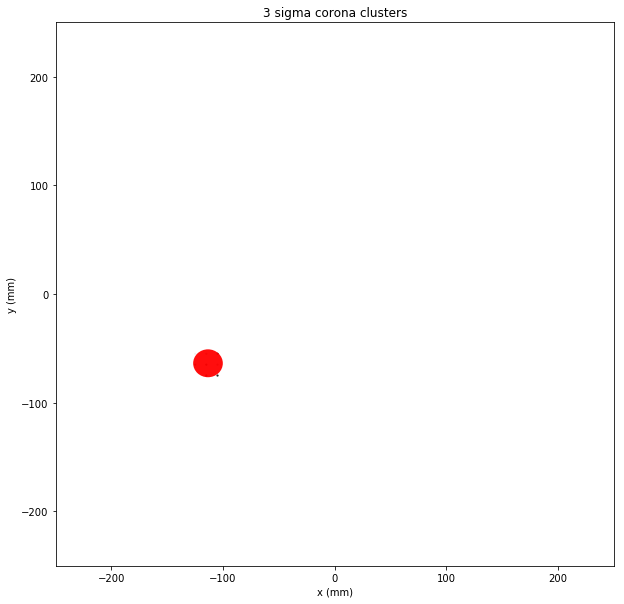

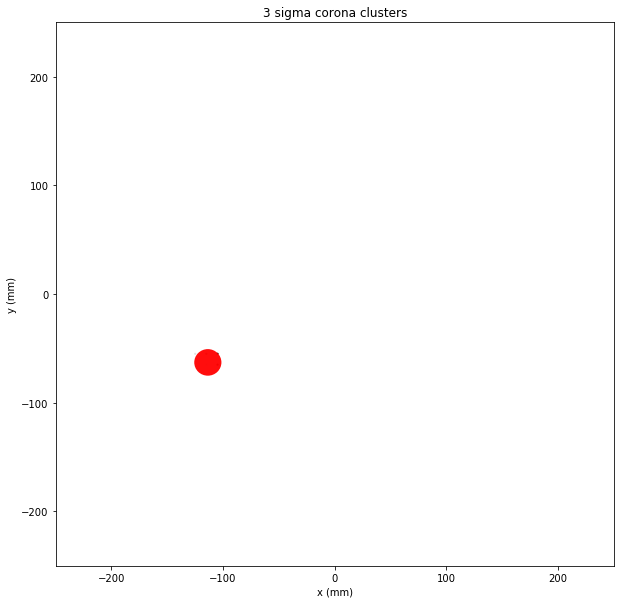

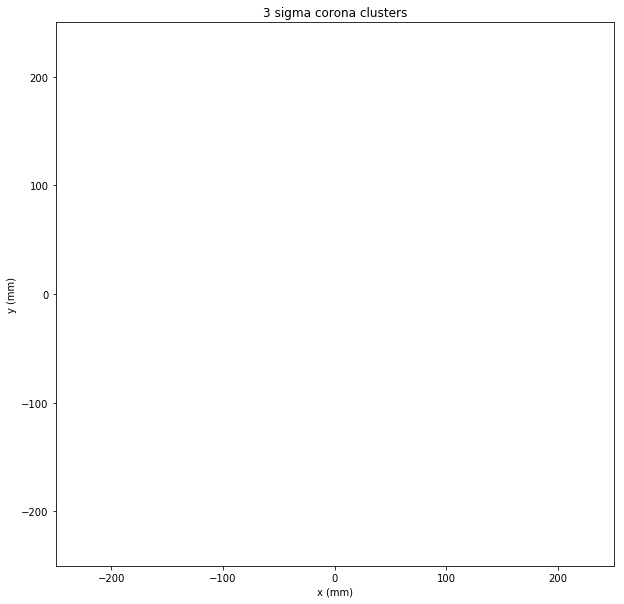

In [57]:
nsig  =  3 # plot param: ellipses with width 2*nsig*Xrms and height 2*nsig*Yrms

S1 = S1s  .get(event_number, {})
S2 = S2s  .get(event_number, {})
Si = S2Sis.get(event_number, {})
n_slices     = len(Si[peak][next(iter(Si[peak]))])

clusters_evt = [[] for i in range(n_slices)]

for slice_no in range(n_slices):
    clusters = compute_xy_position(Si[peak], slice_no)
    clusters_evt.append(clusters)
    
    # Plot SiPMS
    ax = plot_test_slice(*plot_helper(Si[peak], slice_no))
    
    # Plot corona clusters
    for c in clusters: 
        e=Ellipse(xy=(c.X,c.Y), width=2*nsig*c.Xrms, height=2*nsig*c.Yrms)
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(min(.95, c.Q / 200.0*units.pes))
        e.set_facecolor('red')

    plt.title(str(nsig) + ' sigma corona clusters')
    

In [94]:
def plot_event_clusters(ECs, zstart=0*units.mus, figsize=(30,30)):
    fig = plt.figure(figsize=figsize)
    zrange  = units.mus * np.array(range(len(ECs))) + zstart
    
    xs = []
    ys = []
    zs = []
    qs = []
    xrms = []
    yrms = []
    for i in range(len(ECs)):
        for C in ECs[i]:
            xs.append(C.X)
            ys.append(C.Y)
            zs.append(zrange[i])
            qs.append(C.Q)
            xrms.append(C.Xrms)
            yrms.append(C.Yrms)
   
    xs = np.array(xs); ys = np.array(ys);  qs = np.array(qs); 
    zs = np.array(zs) / units.mus
    
    reds  = np.array(qs) / np.array(qs).max()
    color = np.zeros((len(reds),3),dtype=np.float32)
    color[:,0] = reds
    ax = fig.add_subplot(211, projection='3d')
    s1=ax.scatter(zs, xs, ys, c=color,
                   vmin=0,
                   vmax=color.max(),
                   s=np.pi*((np.array(xrms) + np.array(yrms)) / 2 * 3)**2,
                   edgecolors='None', alpha=1)
    ax.set_xlabel('z (microseconds)')
    #ax.set_xlim(zs.min(), zs.max())
    ax.set_ylabel('x (mm)')
    #ax.set_ylim(xs.min(), xs.max())
    #ax.set_ylim(190, xs.max())
    #ax.set_zlim(ys.min(), ys.max())
    #ax.set_zlim(ys.min(), 60)
    ax.set_zlabel('y (mm)')
    ax.grid(True)
    return ax

strange = 0

def plot_nexus_event_hits(ax, hits):
    c = hits[:,3] / hits[:,3].max()
    ax.scatter(hits[:,2] - strange, hits[:,0], hits[:,1], 
                  c=c, cmap=plt.get_cmap('rainbow'),
                  vmin=0, vmax=c.max(),
                  s=200, edgecolors='None')

In [95]:
( S2[0][0][0] - S1[0][0][0] ) / 1000 

26.737500000000001

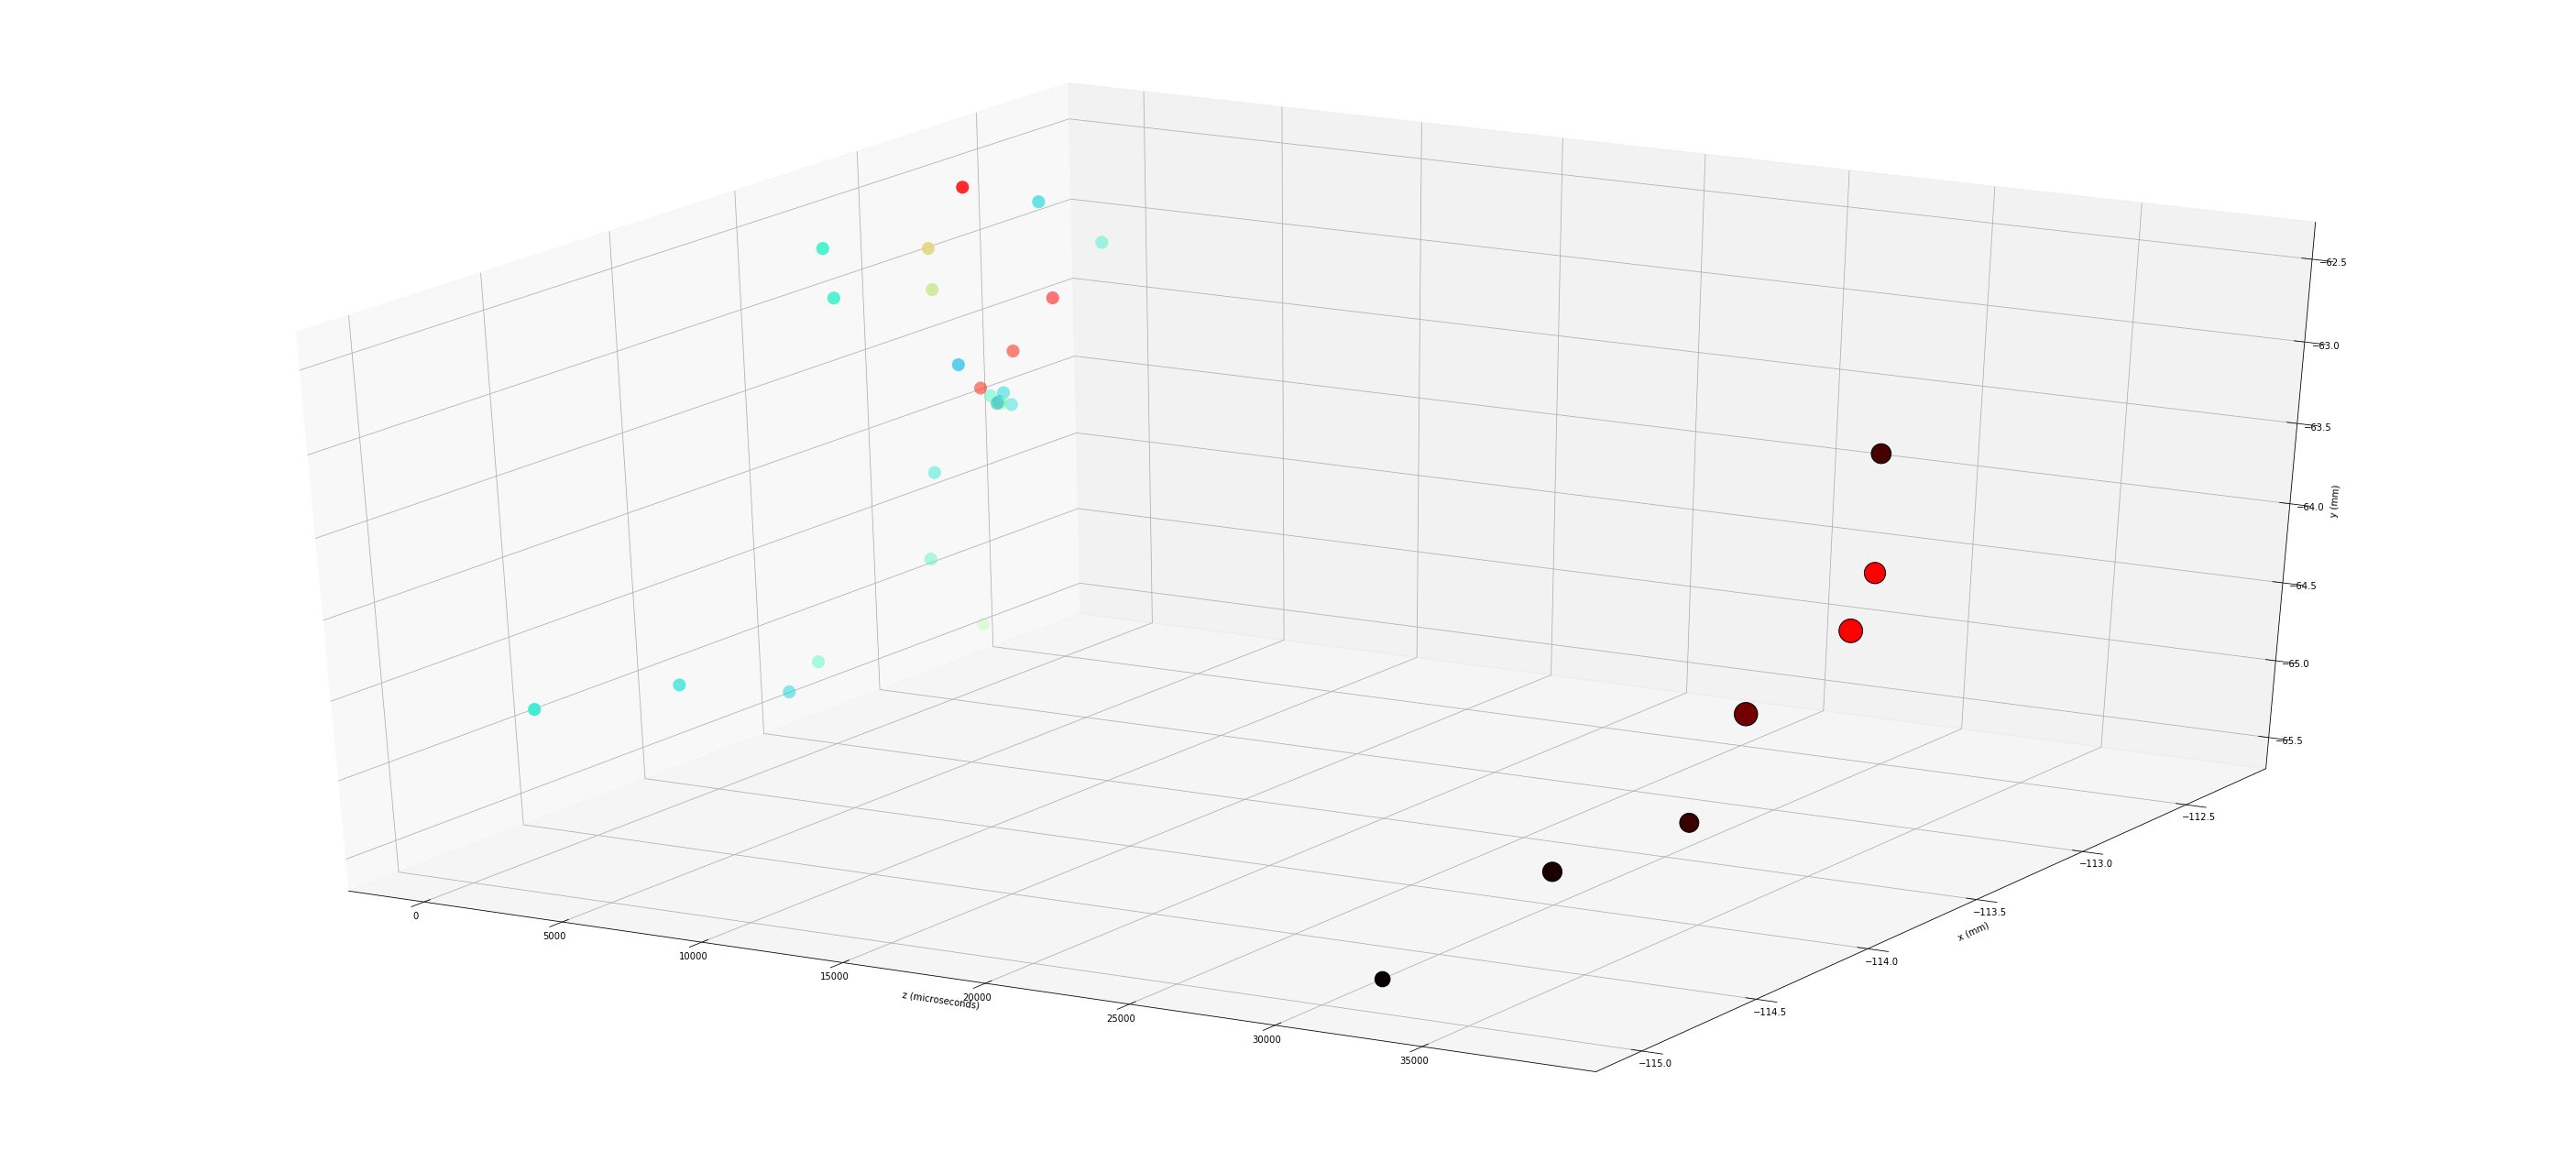

In [96]:
dV = .9
ax = plot_event_clusters(clusters_evt, figsize=(50,50), zstart=(S2[0][0][0]-S1[0][0][0])*dV)
plot_nexus_event_hits(ax, gather_montecarlo_hits(pmap_path)[event_number])
plt.show()

Run corona over a squashed event (sum all time slices)

In [11]:
rclust = {}
for ev in S2Sis:
    Si = S2Sis.get(ev, {})

    # For now, only look at events with one peak, peak 0
    if len(Si) == 1:
        try:
            squashed = {SiPM: np.array([Si[0][SiPM].sum()]) for SiPM in Si[0]}
            rclust[ev] = compute_xy_position(squashed, 0)
        except KeyError: pass

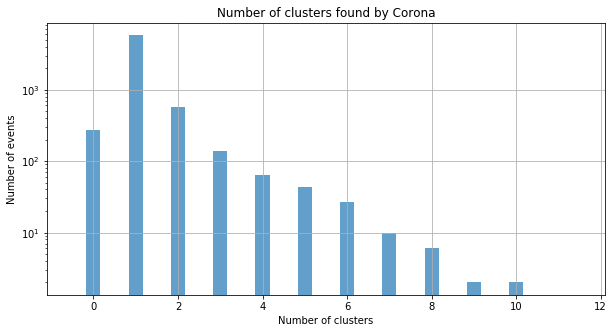

In [12]:
plt.figure(figsize=(10,5))
num_clusters = np.array([len(cs) for cs in rclust.values()])
plt.hist(num_clusters, bins=36, range=(-.5, 11.5), alpha=.7)
plt.title('Number of clusters found by Corona')
plt.xlabel('Number of clusters')
plt.ylabel('Number of events')
plt.yscale('log')
plt.grid(True)
plt.show()

#### Find truth

In [13]:
# Make dict mapping event number to its barycenter
mclust = {}
for evt, hits in gather_montecarlo_hits(pmap_path).items(): 
    mclust[evt] = barycenter(*hits.T)[0]

/Users/alej/Desktop/Valencia/nextic/IC-1/invisible_cities/reco/xy_algorithms.py:23: RuntimeWarning: invalid value encountered in double_scalars
  c    = Cluster(q, x, y, xvar**0.5, yvar**0.5, n)


#### Find Error

In [14]:
xerr = {}
yerr = {}
derr = {}
xpull= {}
ypull= {}
xpull0= {}
ypull0= {}
for evt in rclust: # BUG???
    if len(rclust[evt]) == 1 and evt < 9997:
        rc0 = rclust[evt][0]
        xerr[evt]  =          rc0.X - mclust[evt].X
        yerr[evt]  =          rc0.Y - mclust[evt].Y
        derr[evt]  = np.sqrt(xerr[evt]**2 + yerr[evt]**2)
        
        if rc0.Xrms > 0:
            xpull0[evt] = xerr  [evt] / rc0.Xrms 
            xpull [evt] = xpull0[evt] * rc0.Nsipm
        if rc0.Yrms > 0:
            ypull0[evt] = yerr  [evt] / rc0.Yrms
            ypull [evt] = ypull0[evt] * rc0.Nsipm
        


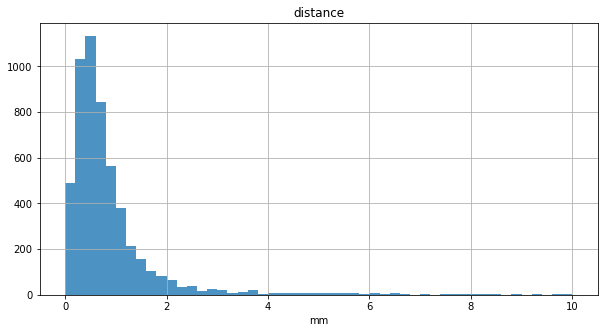

In [15]:
bins = 50
xrg = 0, 10
plt.figure(figsize=(10,5))
plt.title('distance')
plt.xlabel('mm')
plt.hist(list(derr.values()), bins=bins, alpha=.8, range=xrg)
#plt.yscale('log')
plt.grid(True)
plt.show()

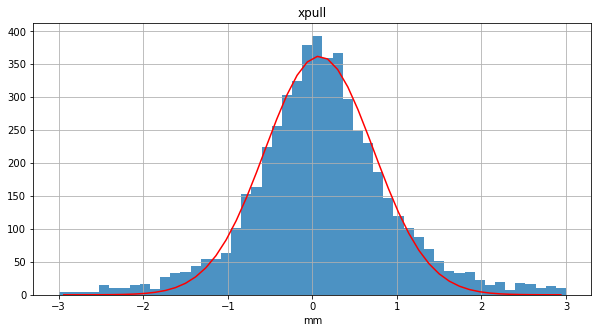

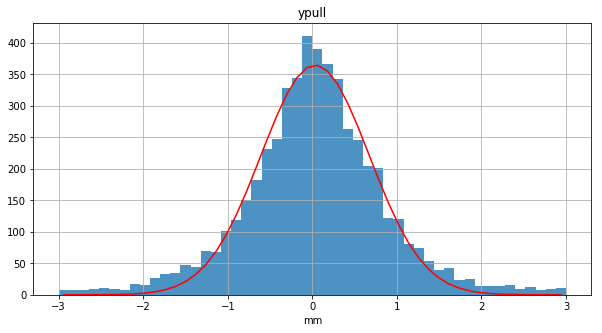

In [16]:
xrg = -3,3
plt.figure(figsize=(10,5))
plt.title('xpull')
plt.xlabel('mm')
y, x, _ = \
plt.hist(list(xpull.values()), bins=bins, alpha=.8, range=xrg)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 0, 1))
plt.plot(x, f.fn(x), "r-")
plt.grid(True)
plt.show()
plt.figure(figsize=(10,5))
y, x, _ = \
plt.hist(list(ypull.values()), bins=bins, alpha=.8, range=xrg)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 0, 1))
plt.plot(x, f.fn(x), "r-")
plt.grid(True)
plt.title('ypull')
plt.xlabel('mm')
plt.show()

/Users/alej/Desktop/Valencia/nextic/IC-1/invisible_cities/core/fit_functions.py:102: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


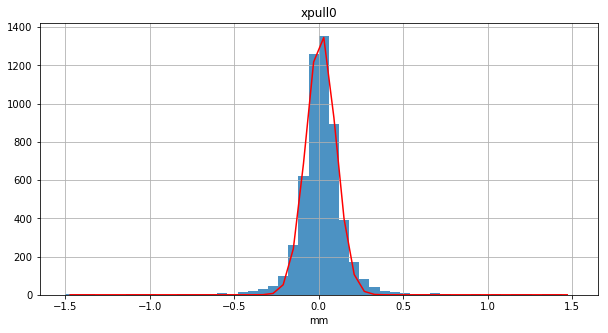

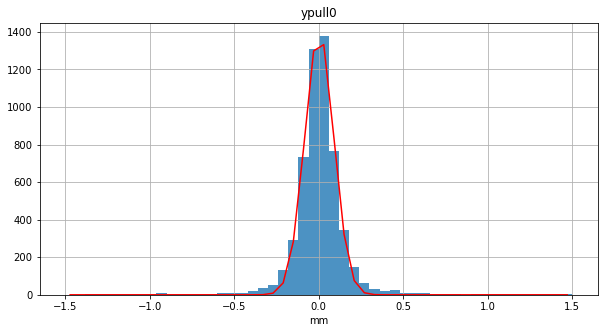

In [17]:
xrg = -1.5, 1.5
plt.figure(figsize=(10,5))
plt.title('xpull0')
plt.xlabel('mm')
y, x, _ = \
plt.hist(list(xpull0.values()), bins=bins, alpha=.8, range=xrg)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 0, 1))
plt.plot(x, f.fn(x), "r-")
plt.grid(True)
plt.show()
plt.figure(figsize=(10,5))
y, x, _ = \
plt.hist(list(ypull0.values()), bins=bins, alpha=.8, range=xrg)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 0, 1))
plt.plot(x, f.fn(x), "r-")
plt.grid(True)
plt.title('ypull0')
plt.xlabel('mm')
plt.show()

[  5.92924190e+02   6.87260411e-02   4.89964511e-01]


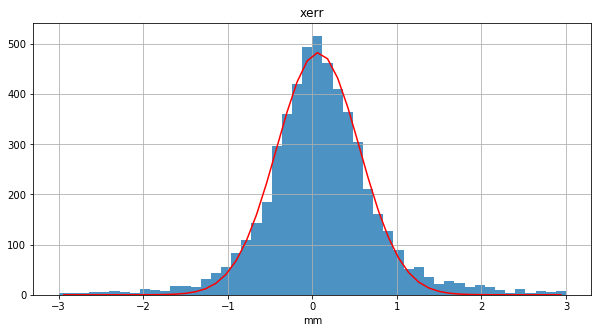

[  5.95860128e+02   2.49920153e-02   4.85927186e-01]


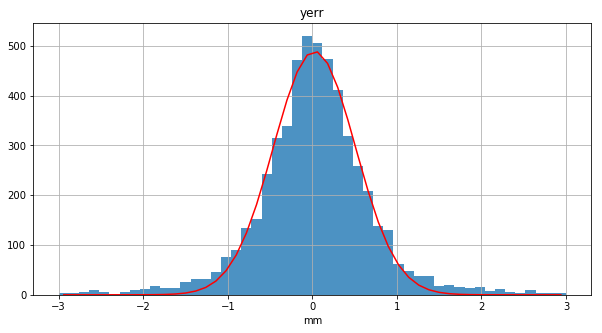

In [18]:
xrg = -3, 3
plt.figure(figsize=(10,5))
plt.title('xerr')
plt.xlabel('mm')
y, x, _ = \
plt.hist(list(xerr.values()), bins=bins, alpha=.8, range=xrg)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 0, 1))
plt.plot(x, f.fn(x), "r-")
print(f.values)

plt.grid(True)
plt.show()
plt.figure(figsize=(10,5))
y, x, _ = \
plt.hist(list(yerr.values()), bins=bins, alpha=.8, range=xrg)
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e3, 0, 1))
plt.plot(x, f.fn(x), "r-")
print(f.values)
plt.grid(True)
plt.title('yerr')
plt.xlabel('mm')
plt.show()